# Modelos.
Los modelos va a estar condicionados por las fortalezas de nuestra regla.
Hemos convertido el problema casí en deterministico Desarrollamos los modelos requeridos en la práctica y añadimos un modelos base solo con nuestra regla para comparar.

No hacemos sobremuestreo o submuestreo, no es necesario. El ajuste de hiperparametros tampoco va a aportar grandes mejoras. Se sustiruye por entrenar todos los modelos con pesos, para que penalice los errores en la clase minotiraria. LightGBM fue muy sensible a este efecto, pasó de fallar mucho a tener de los mejores rendimientos cuandos se entrenó con pesos balanceados.

In [ ]:
import os, sys

In [ ]:
# Impostamos sklearnex y patcheamos SVC, nos ahorrará de 5 horas a minutos en el clasificador Support Vector.

from sklearnex import patch_sklearn
patch_sklearn("SVC")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [ ]:
# primero todas las librerías por bloques
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import warnings
from scipy.stats import pearsonr, chi2_contingency
from itertools import combinations
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

from sklearn.linear_model import Lasso, LogisticRegression

from sklearn.preprocessing import StandardScaler


import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder



from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve,PrecisionRecallDisplay,ConfusionMatrixDisplay, \
                            accuracy_score,plot_confusion_matrix,average_precision_score

from sklearn.naive_bayes import GaussianNB                          
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix


import scikitplot as skplt
import matplotlib.pyplot as plt

from sklearn.inspection import PartialDependenceDisplay

import lightgbm as lgb

from sklearn.svm import SVC


import xgboost as xgb





In [ ]:
# opciones de visualización
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [ ]:
data = pd.read_parquet('../data/fraud_detection_engenering.parquet')
data.columns= data.columns.str.lower()

In [ ]:
data[['segmento','fraud_rules']]=data[['segmento','fraud_rules']].astype('category')

In [ ]:
categorical_vars=[x for x in data.columns if data[x].dtypes=='category']
numerical_vars = [[x for x in data.columns if data[x].dtypes !='category']]

In [ ]:
# From feature selection.
selected_feaures_target=['step',  'oldbalanceorg', 'newbalancedest', 'step_importance', 'fraud_rules', 'errorbalanceorig', 'errorbalancedest','isfraud']

In [ ]:
data=data[selected_feaures_target]

## Introducióm modelos.

Los resultados tan espectaculares conseguidos en la fase de selección de caracterisiticas con RandomForrest nos lleva a darle una menor importancia a aspectos como el balanceo de clases o a la optimización de hiperparametros de los modelos, ya que las ganancias relativas de acierto que nos proporcionarán serán muy bajas.
Como el tiempo apremia, primero contruimos todos los modelos que pide la práctica y sí da tiempo volveremos a estas fases.

Eso si, en todos los modelos posibles utilizaremos los weigts para que le den mas importancia a la clase minoritaria. En el caso RandomForrest:

Una técnica simple para modificar un árbol de decisión para la clasificación desequilibrada es cambiar el peso que tiene cada clase al calcular la puntuación de " impureza " de un punto de división elegido.

La impureza mide qué como de mezclados están los grupos de muestras para una división dada en el conjunto de datos de entrenamiento y generalmente se mide con Gini o entropía . El cálculo puede estar sesgado de modo que se favorezca una mezcla a favor de la clase minoritaria, permitiendo algunos falsos positivos para la clase mayoritaria.

En todos los metodos utilizados, se puede modificar los pesos de las clases.

Se hicieron pruebas con submuestreo, sobremuestreo y SMOTE, no variando los resultados.

In [ ]:
# Hacemos nuestro sets de features y target.
X=data.drop(['isfraud'],axis=1)
y=data['isfraud']

In [ ]:
def generate_sets(X,y, random_state):

  X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.20,random_state= random_state,stratify=y)

  # Construimos dummies para las variables categoricas.

  list_columns_cat = [col for col in X_train.columns if col in categorical_vars ]
  list_other = list(set(X_train.columns)-set(list_columns_cat))
  one = ce.OneHotEncoder(cols=list_columns_cat)
  model = one.fit(X_train)

  X_train_t = model.transform(X_train, y_train)
  X_test_t = model.transform(X_test, y_test)

  # Estandarizamos todas las variables, media 0, desviacion estandar 1.

  scaler = StandardScaler()
  model_scaled = scaler.fit(X_train_t)
  X_train_scaled = pd.DataFrame(scaler.transform(X_train_t), columns=X_train_t.columns, index=X_train_t.index)
  X_test_scaled = pd.DataFrame(scaler.transform(X_test_t), columns=X_test_t.columns, index=X_test.index)

  return X_train_scaled,X_test_scaled,y_train,y_test


In [ ]:
X_train_scaled,X_test_scaled,y_train,y_test = generate_sets(X,y, 42)

In [ ]:
def evaluate_model(name,y_test, y_pred, ypred_proba = None):
  if ypred_proba is not None:
      print('ROC-AUC score of the model: {}'.format(roc_auc_score(y_test, ypred_proba[:, 1])))
  print('Accuracy of the model: {}\n'.format(accuracy_score(y_test, y_pred)))
  print('Classification report: \n{}\n'.format(classification_report(y_test, y_pred)))
  print('Confusion matrix: \n{}\n'.format(confusion_matrix(y_test, y_pred)))
  print('Normalized confusion matrix: \n{}\n'.format(confusion_matrix(y_test, y_pred,normalize='all')))

  print("Average Precision-Recall score:\t", average_precision_score(y_test, y_pred,average='macro'))

  report=classification_report(y_test, y_pred,output_dict=True)
  rfc_frame=pd.DataFrame.from_dict((report['macro avg']), orient='index').T
  rfc_frame['accuracy']=report['accuracy']
  rfc_frame['nombre']=name
  rfc_frame['True_neg']=confusion_matrix(y_test,y_pred)[0][0]
  rfc_frame['False_neg']=confusion_matrix(y_test,y_pred)[0][1]
  rfc_frame['False_posit']=confusion_matrix(y_test,y_pred)[1][0]
  rfc_frame['True_posit']=confusion_matrix(y_test,y_pred)[1][1]
  rfc_frame['Aveg_Precision-Recall']=average_precision_score(y_test, y_pred,average='macro')

  rfc_frame=rfc_frame.drop(columns=['support'])
  return rfc_frame



In [ ]:
def plot_conf_matrix(model, X=X_test_scaled, y=y_test):

  plt.rcParams.update({'figure.figsize':(4,4), 'figure.dpi':100})

  # Plot non-normalized confusion matrix
  titles_options = [("Confusion matrix, without normalization", None),
                    ("Normalized confusion matrix", 'true')]
  for title, normalize in titles_options:
      disp = plot_confusion_matrix(model , X, y,
                                  cmap=plt.cm.Blues,
                                  normalize=normalize,colorbar=False )


In [ ]:
def roc_prec_rec_curves(y_test,y_prob):
  plt.rcParams.update({'figure.figsize':(8,4), 'figure.dpi':100})
  fig, ax = plt.subplots(1, 2)


  # keep probabilities for the positive outcome only
  yhat = y_prob[:, 1]
  # calculate roc curves
  fpr, tpr, thresholds = roc_curve(y_test, yhat)
  # plot the roc curve for the model
  ax[0].plot([0,1], [0,1], linestyle='--', label='No Skill')
  ax[0].plot(fpr, tpr, marker='.', label='Random Forest')
  # axis labels
  ax[0].set_xlabel('False Positive Rate')
  ax[0].set_ylabel('True Positive Rate')

  # calculate the g-mean for each threshold
  gmeans = np.sqrt(tpr * (1-fpr))
  ix = np.argmax(gmeans)
  print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
  ax[0].scatter(fpr[ix], tpr[ix], s=100, marker='o', color='black', label='Best')
  ax[0].legend()


  # calculate pr-curve
  precision, recall, thresholds = precision_recall_curve(y_test, yhat)

  # convert to f score
  fscore = (2 * precision * recall) / (precision + recall)
  # locate the index of the largest f score
  ix = np.argmax(fscore)
  print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
  # plot the roc curve for the model
  no_skill = len(y_test[y_test==1]) / len(y_test)
  ax[1].plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
  ax[1].plot(recall, precision, marker='.', label='Random Forest')
  ax[1].scatter(recall[ix], precision[ix], s=100, marker='o', color='black', label='Best')
  # axis labels
  ax[1].set_xlabel('Recall')
  ax[1].set_ylabel('Precision')
  ax[1].legend()
  plt.show()


In [ ]:
def fit_pred(model,X_train,y_train,X_test,y_test):
  model.fit(X_train,y_train)
  
  y_pred=model.predict(X_test)
  y_prob= model.predict_proba(X_test)
  return y_pred, y_prob


### 1. Modelo base imputando todos los casos a que no haya fraude.

Modelo base para ver las mejoras que vamso proporcionado.
y_pred=0, para todos los casos.

Obtenemos nuestro peor modelo posible, observamos que en caso de clases tan desbalanceadas las precisión no es una buena medida. Tendremso que mejorar el 0.999989, casi la perfección apra otros modelos.
Me quedo para comparar las medidas en terminos de macro avg, donde se le otorga el mismo peso a cada clase. En este caso observamos metricas pesimas, 0.5, ya que no acierta ningun caso positivo.


In [ ]:

dummy_clf = DummyClassifier(strategy="most_frequent")
y_pred_base, y_prob_base =fit_pred(dummy_clf,X_train_scaled,y_train,X_test_scaled,y_test)

In [ ]:
resutados_base=evaluate_model('modelo_base',y_test,y_pred_base)

Accuracy of the model: 0.9989128102424719

Classification report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    209487
           1       0.00      0.00      0.00       228

    accuracy                           1.00    209715
   macro avg       0.50      0.50      0.50    209715
weighted avg       1.00      1.00      1.00    209715


Confusion matrix: 
[[209487      0]
 [   228      0]]

Normalized confusion matrix: 
[[0.99891281 0.        ]
 [0.00108719 0.        ]]

Average Precision-Recall score:	 0.0010871897575280738


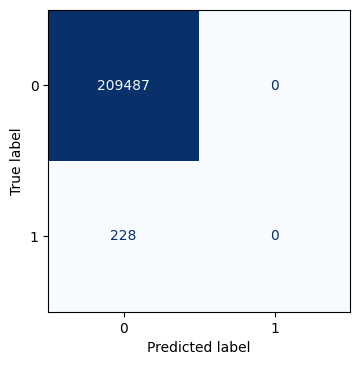

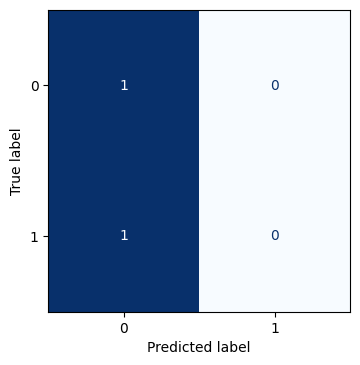

In [ ]:
plot_conf_matrix(dummy_clf)

Best Threshold=1.000000, G-Mean=0.000
Best Threshold=0.000000, F-Score=0.002


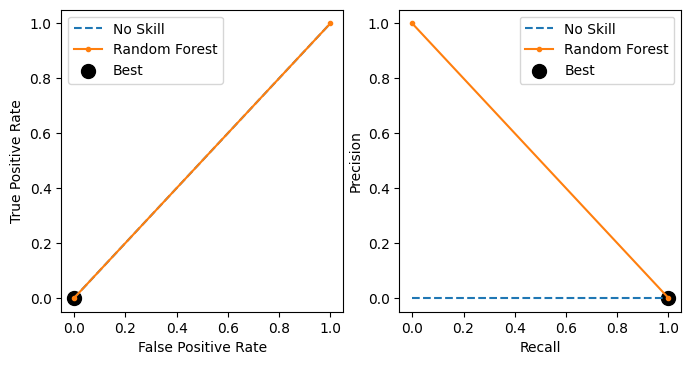

In [ ]:
roc_prec_rec_curves(y_test,y_prob_base)

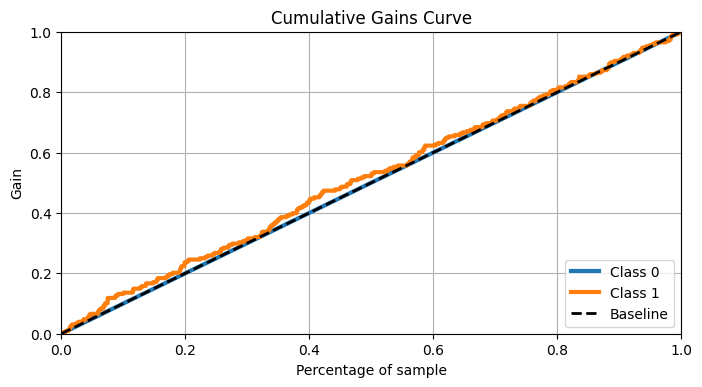

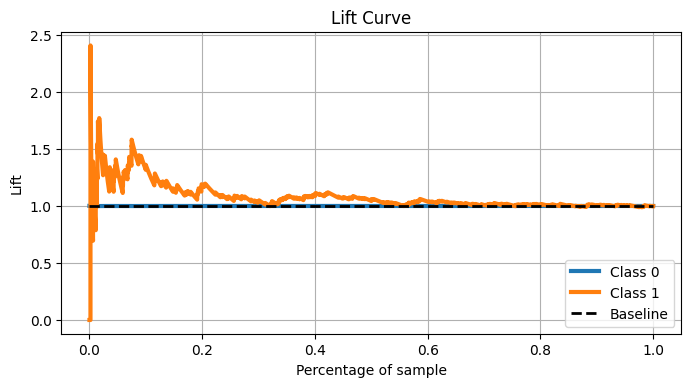

In [ ]:
import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_cumulative_gain(y_test, y_prob_base)
skplt.metrics.plot_lift_curve(y_test, y_prob_base)
plt.show()

### 2. Modelo base solo con fraud_rules.

Entrenamos un modelo solo con nuestra regla de fraude, que servirá para comparar sí algun modelo lo supera.

In [ ]:
model_gnb = GaussianNB()

y_pred_gnb, y_prob_gnb = fit_pred(model_gnb ,X_train_scaled[['fraud_rules_1']],y_train,X_test_scaled[['fraud_rules_1']],y_test)

In [ ]:
resutados_naive = evaluate_model('base_rules',y_test,y_pred_gnb)

Accuracy of the model: 0.9999666213670935

Classification report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    209487
           1       1.00      0.97      0.98       228

    accuracy                           1.00    209715
   macro avg       1.00      0.98      0.99    209715
weighted avg       1.00      1.00      1.00    209715


Confusion matrix: 
[[209487      0]
 [     7    221]]

Normalized confusion matrix: 
[[9.98912810e-01 0.00000000e+00]
 [3.33786329e-05 1.05381112e-03]]

Average Precision-Recall score:	 0.9693316242469416


In [ ]:
resultados=pd.concat([resutados_base,resutados_naive],axis=0)

Best Threshold=1.000000, G-Mean=0.985
Best Threshold=1.000000, F-Score=0.984


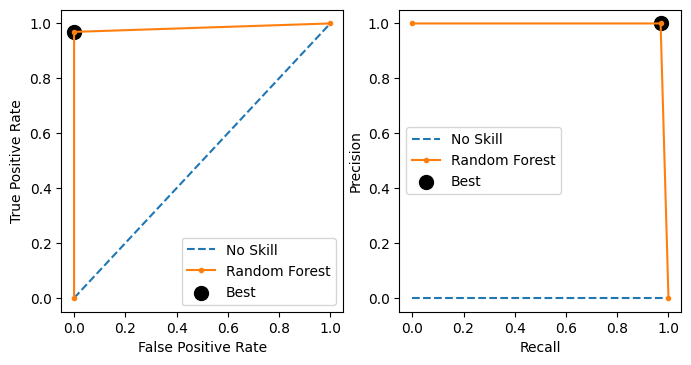

In [ ]:
roc_prec_rec_curves(y_test,y_prob_gnb)

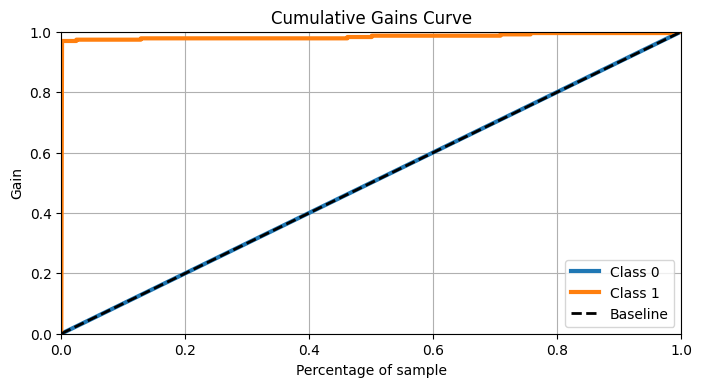

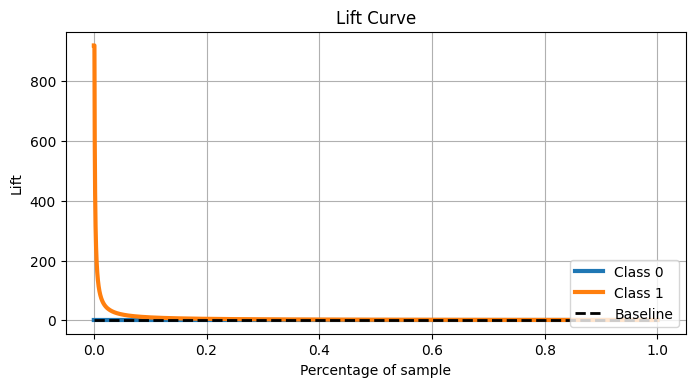

In [ ]:
skplt.metrics.plot_cumulative_gain(y_test, y_prob_gnb)
skplt.metrics.plot_lift_curve(y_test, y_prob_gnb)
plt.show()

### 2. Modelo GLM: ridge.

In [ ]:
model_lr_ridge = LogisticRegression(C = 0.001, penalty = 'l1',class_weight='balanced',solver= 'liblinear')
y_pred_ridge, y_prob_ridge =fit_pred(model_lr_ridge,X_train_scaled,y_train,X_test_scaled,y_test)



In [ ]:
resutados_ridge=evaluate_model('modelo_ridge',y_test,y_pred_ridge)

Accuracy of the model: 0.9993801111031638

Classification report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    209487
           1       0.64      0.98      0.77       228

    accuracy                           1.00    209715
   macro avg       0.82      0.99      0.89    209715
weighted avg       1.00      1.00      1.00    209715


Confusion matrix: 
[[209362    125]
 [     5    223]]

Normalized confusion matrix: 
[[9.98316763e-01 5.96047016e-04]
 [2.38418806e-05 1.06334788e-03]]

Average Precision-Recall score:	 0.62677570717607


In [ ]:
resultados=pd.concat([resultados,resutados_ridge],axis=0)

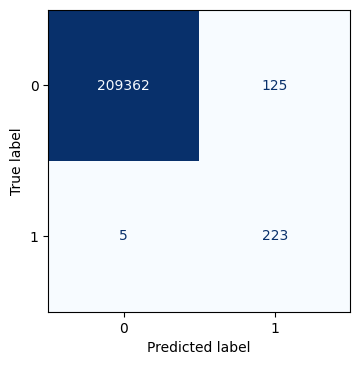

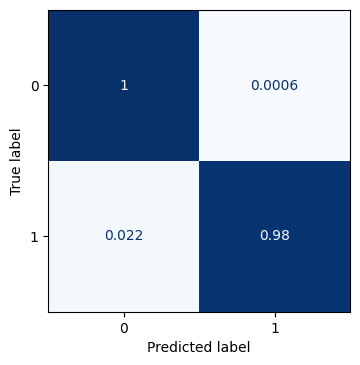

In [ ]:
plot_conf_matrix(model_lr_ridge)

Best Threshold=0.947977, G-Mean=0.989
Best Threshold=0.999597, F-Score=0.967


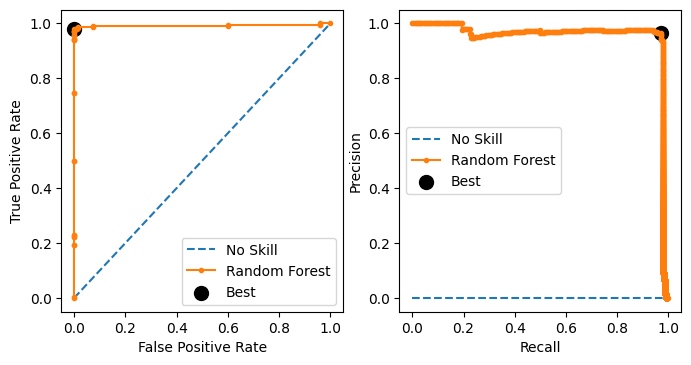

In [ ]:
roc_prec_rec_curves(y_test,y_prob_ridge)

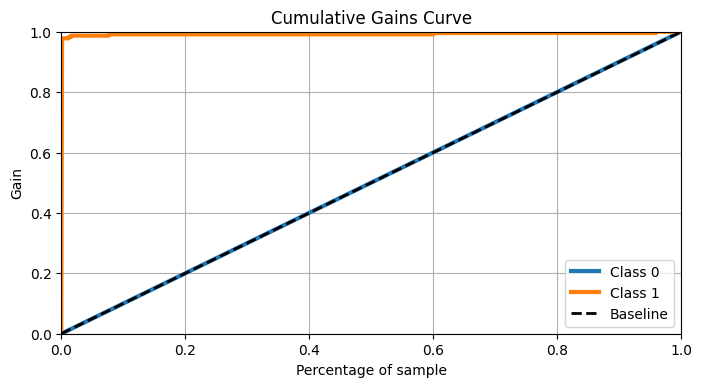

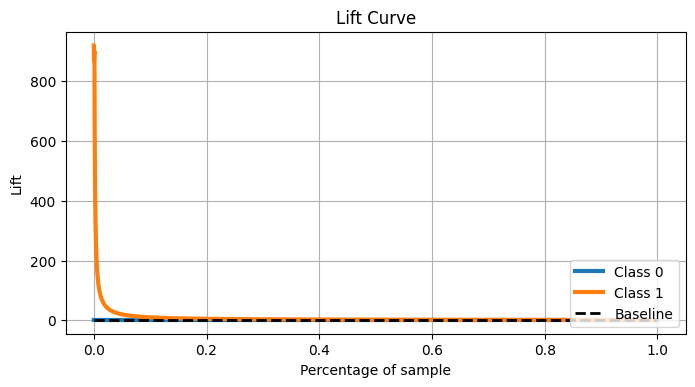

In [ ]:
skplt.metrics.plot_cumulative_gain(y_test, y_prob_ridge)
skplt.metrics.plot_lift_curve(y_test, y_prob_ridge)
plt.show()

### 3. Modelo SVM.

Prescindimos del cáculo de probabilidades y gráficos realcionados, ya que eterniza el entrenamiento.

Lo hemos acelarado con scikit-learn-intelex, y falla cuando se calculan probabilidades. El metodo tradicional termina en 5 horas.

In [ ]:

model_svc = SVC(gamma='scale', class_weight='balanced')

model_svc.fit(X_train_scaled,y_train)

y_pred_svc=model_svc.predict(X_test_scaled)


In [ ]:
resultados_svc=evaluate_model('modelo_svc',y_test,y_pred_svc)

Accuracy of the model: 0.9999380111103163

Classification report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    209487
           1       1.00      0.94      0.97       228

    accuracy                           1.00    209715
   macro avg       1.00      0.97      0.99    209715
weighted avg       1.00      1.00      1.00    209715


Confusion matrix: 
[[209487      0]
 [    13    215]]

Normalized confusion matrix: 
[[9.98912810e-01 0.00000000e+00]
 [6.19888897e-05 1.02520087e-03]]

Average Precision-Recall score:	 0.9430444450300346


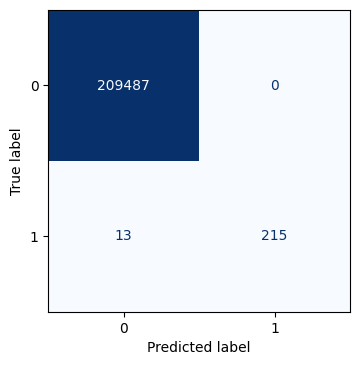

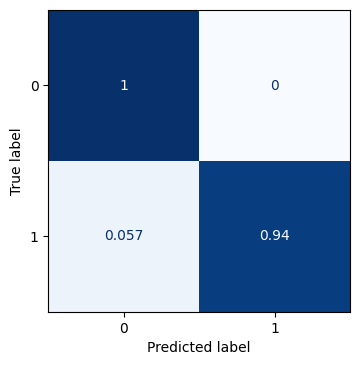

In [ ]:
plot_conf_matrix(model_svc)

In [ ]:
resultados=pd.concat([resultados,resultados_svc] ,axis=0)

In [ ]:
resultados

precision  recall  f1-score  accuracy        nombre  True_neg  False_neg  \
0     0.4995  0.5000    0.4997    0.9989   modelo_base    209487          0   
0     1.0000  0.9846    0.9922    1.0000    base_rules    209487          0   
0     0.8204  0.9887    0.8870    0.9994  modelo_ridge    209362        125   
0     1.0000  0.9715    0.9853    0.9999    modelo_svc    209487          0   

   False_posit  True_posit  Aveg_Precision-Recall  
0          228           0                 0.0011  
0            7         221                 0.9693  
0            5         223                 0.6268  
0           13         215                 0.9430

### Modelo RandomForest

In [ ]:
model_rfc=RandomForestClassifier(n_estimators= 100, max_features='sqrt', max_depth=8, criterion='gini',class_weight='balanced')
y_pred_rfc, y_prob_rfc = fit_pred(model_rfc,X_train_scaled,y_train,X_test_scaled,y_test)

In [ ]:
resultados_rfc=evaluate_model('modelo_randomForrest',y_test,y_pred_rfc)

Accuracy of the model: 0.999971389743223

Classification report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    209487
           1       1.00      0.97      0.99       228

    accuracy                           1.00    209715
   macro avg       1.00      0.99      0.99    209715
weighted avg       1.00      1.00      1.00    209715


Confusion matrix: 
[[209487      0]
 [     6    222]]

Normalized confusion matrix: 
[[9.98912810e-01 0.00000000e+00]
 [2.86102568e-05 1.05857950e-03]]

Average Precision-Recall score:	 0.9737128207830928


In [ ]:
resultados=pd.concat([resultados,resultados_rfc] ,axis=0)

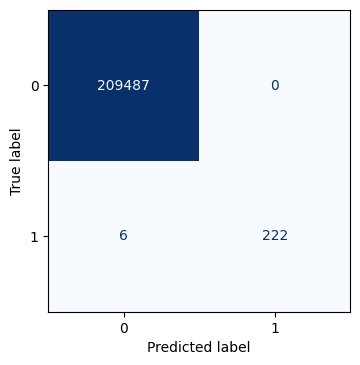

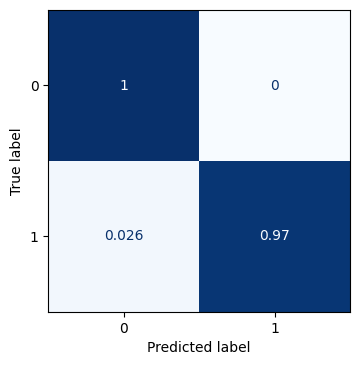

In [ ]:
plot_conf_matrix(model_rfc)

Best Threshold=0.111064, G-Mean=0.990
Best Threshold=0.342545, F-Score=0.989


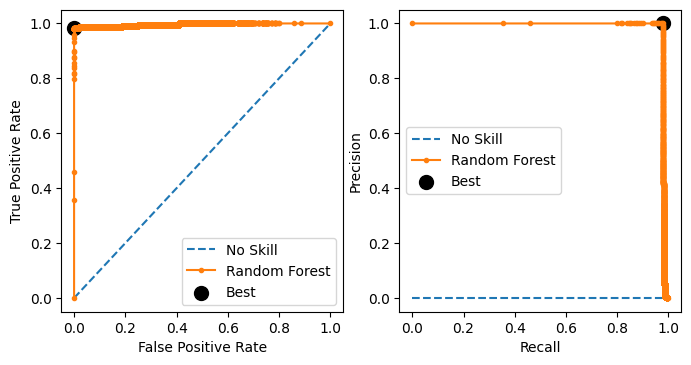

In [ ]:
roc_prec_rec_curves(y_test,y_prob_rfc)

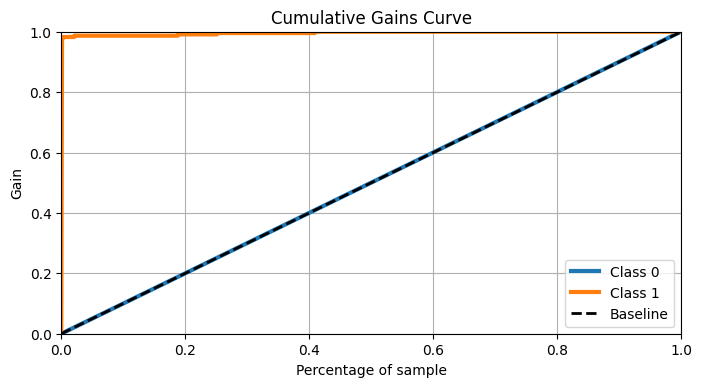

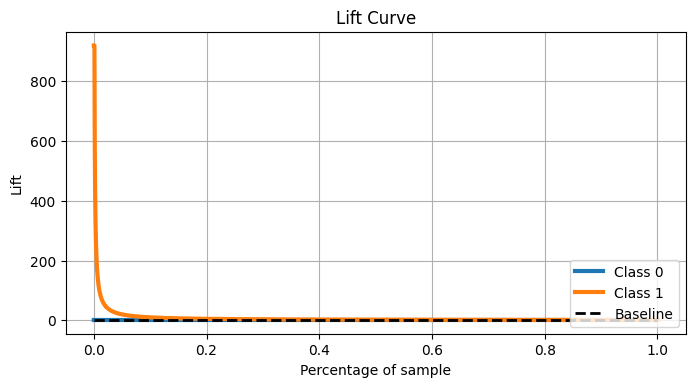

In [ ]:
skplt.metrics.plot_cumulative_gain(y_test, y_prob_rfc)
skplt.metrics.plot_lift_curve(y_test, y_prob_rfc)
plt.show()

### Modelo XGBBoost

Tenemos que calcular los pesos de las clases, como las veces que la clase mayoritaria supone sobre la minoritaria y pasarlo como parametro.

In [ ]:


weights_xgb = (y_train == 0).sum() / (1.0 * (y_train == 1).sum())

model_xgb = xgb.XGBClassifier(max_depth = 8, scale_pos_weight = weights_xgb, n_jobs = 4)

y_pred_xgb, y_prob_xgb =fit_pred(model_xgb,X_train_scaled,y_train,X_test_scaled,y_test)


In [ ]:
resultados_xgb = evaluate_model('modelo_xgb',y_test,y_pred_xgb)

Accuracy of the model: 0.9999666213670935

Classification report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    209487
           1       0.99      0.98      0.98       228

    accuracy                           1.00    209715
   macro avg       1.00      0.99      0.99    209715
weighted avg       1.00      1.00      1.00    209715


Confusion matrix: 
[[209485      2]
 [     5    223]]

Normalized confusion matrix: 
[[9.98903273e-01 9.53675226e-06]
 [2.38418806e-05 1.06334788e-03]]

Average Precision-Recall score:	 0.9694000602042344


In [ ]:
resultados=pd.concat([resultados,resultados_xgb] ,axis=0)

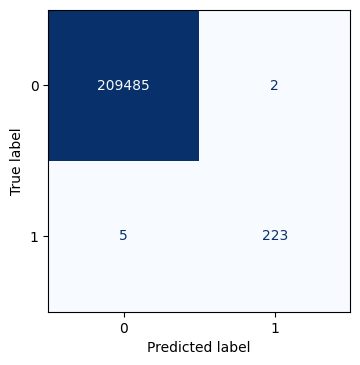

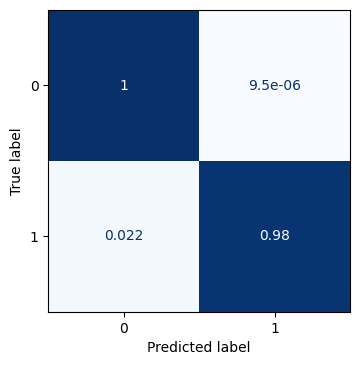

In [ ]:
plot_conf_matrix(model_xgb)

Best Threshold=0.004276, G-Mean=0.992
Best Threshold=0.961872, F-Score=0.989


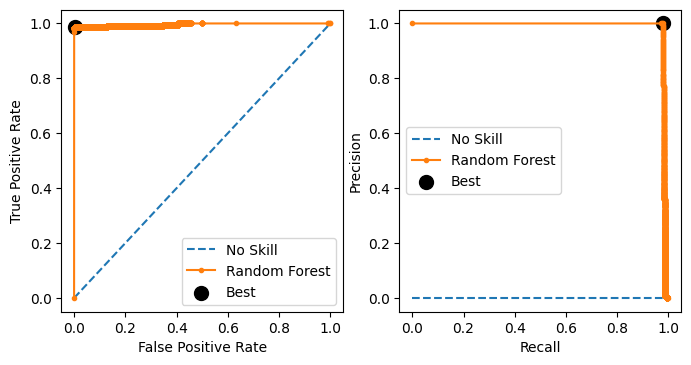

In [ ]:
roc_prec_rec_curves(y_test,y_prob_xgb)

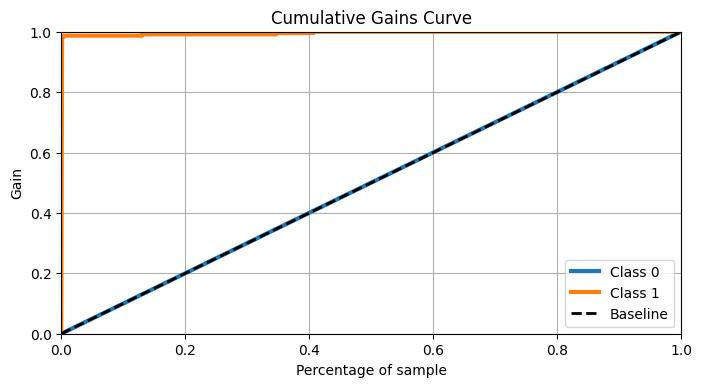

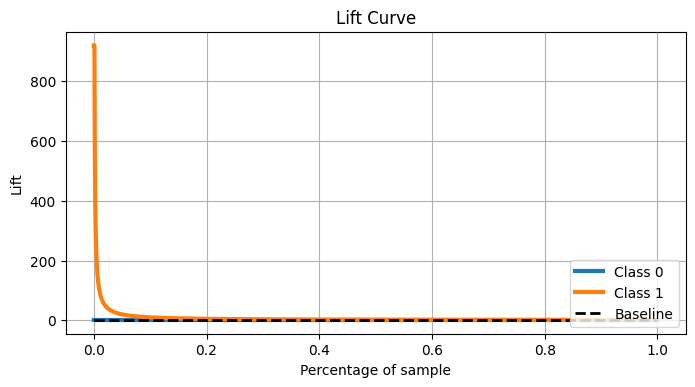

In [ ]:
skplt.metrics.plot_cumulative_gain(y_test, y_prob_xgb)
skplt.metrics.plot_lift_curve(y_test, y_prob_xgb)
plt.show()

### Modelo LightGBM

In [ ]:
import lightgbm as lgb

model_lgb = lgb.LGBMClassifier(class_weight = 'balanced')
y_pred_lgb, y_prob_lgb = fit_pred(model_lgb ,X_train_scaled,y_train,X_test_scaled,y_test)



In [ ]:
resultados_lgb = evaluate_model('modelo_lgb',y_test,y_pred_lgb)

Accuracy of the model: 0.9999570846148345

Classification report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    209487
           1       0.98      0.98      0.98       228

    accuracy                           1.00    209715
   macro avg       0.99      0.99      0.99    209715
weighted avg       1.00      1.00      1.00    209715


Confusion matrix: 
[[209483      4]
 [     5    223]]

Normalized confusion matrix: 
[[9.98893737e-01 1.90735045e-05]
 [2.38418806e-05 1.06334788e-03]]

Average Precision-Recall score:	 0.9608593005714273


In [ ]:
resultados=pd.concat([resultados,resultados_lgb] ,axis=0)

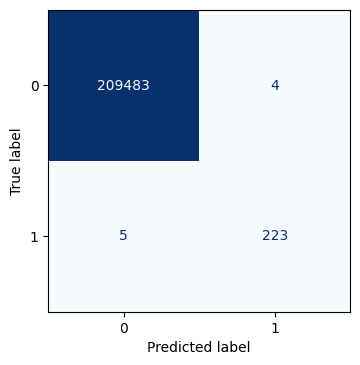

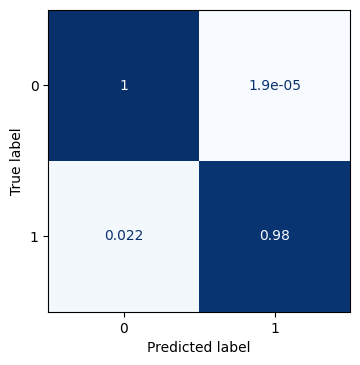

In [ ]:
plot_conf_matrix(model_lgb)

Best Threshold=0.005864, G-Mean=0.991
Best Threshold=0.993166, F-Score=0.987


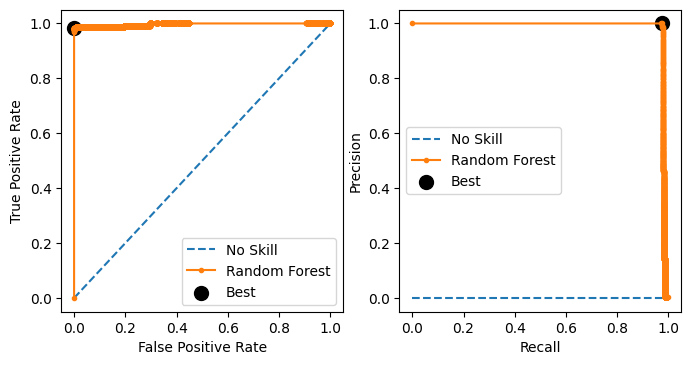

In [ ]:
roc_prec_rec_curves(y_test,y_prob_lgb)

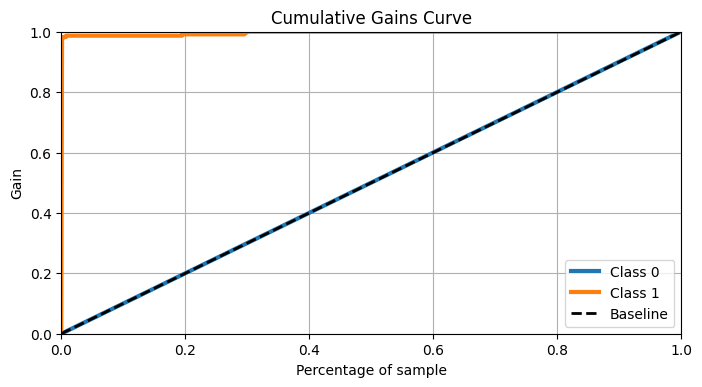

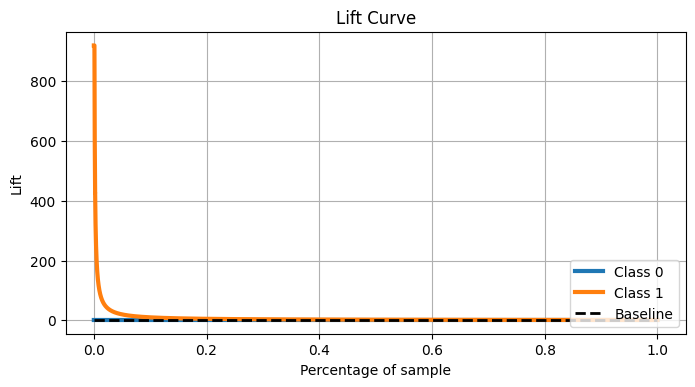

In [ ]:
skplt.metrics.plot_cumulative_gain(y_test, y_prob_lgb)
skplt.metrics.plot_lift_curve(y_test, y_prob_lgb)
plt.show()

### Modelo elegido.

A la vista de lso resultado obtenidos, nos quedamos con Randomforrest, que con métricas muy parecidas a lightgbm consigue unos resultados espectaculares.
La diferencia es que es capaz de no generar ningun falso negativo en multiples pruebas. Y detecta la inmensa mayoria de los positivos.

Smo cosncientes que con nuestra ingenieria de caracteristicas hemos reducido el problema a los modelos en un 98.5 % con nuestro fraud_rules, aun así son capaces de mejorar este grandisiomo porcentaje de acierto.

El mejor modelo es RandomForest que es capaz de mejorar en alguno ( siempre pocos) a nuestro modelo base con reglas. En el caso mostrado lo mejora en uno. Pero nunca genera Falsos Negativos. 

In [ ]:
resultados.sort_values(by='Aveg_Precision-Recall',ascending=False)

precision  recall  f1-score  accuracy                nombre  True_neg  \
0     1.0000  0.9868    0.9933    1.0000  modelo_randomForrest    209487   
0     0.9955  0.9890    0.9923    1.0000            modelo_xgb    209485   
0     1.0000  0.9846    0.9922    1.0000            base_rules    209487   
0     0.9912  0.9890    0.9901    1.0000            modelo_lgb    209483   
0     1.0000  0.9715    0.9853    0.9999            modelo_svc    209487   
0     0.8204  0.9887    0.8870    0.9994          modelo_ridge    209362   
0     0.4995  0.5000    0.4997    0.9989           modelo_base    209487   

   False_neg  False_posit  True_posit  Aveg_Precision-Recall  
0          0            6         222                 0.9737  
0          2            5         223                 0.9694  
0          0            7         221                 0.9693  
0          4            5         223                 0.9609  
0          0           13         215                 0.9430  
0        125            5         223                 0.6268  
0          0          228           0                 0.0011

### Interpretabilidad.

Revisemos la importancia de los features en random forrest, en xgboost y en ligth. En los tres casos, fraud_rules sobresale ampliamente como el feature que mas ayuda a clasificar.

Acompañamos dos ejemplos de interpretación con lime, uno fraude y otro legitimo, fraud_rules_2 toma protagonismo absoluto.

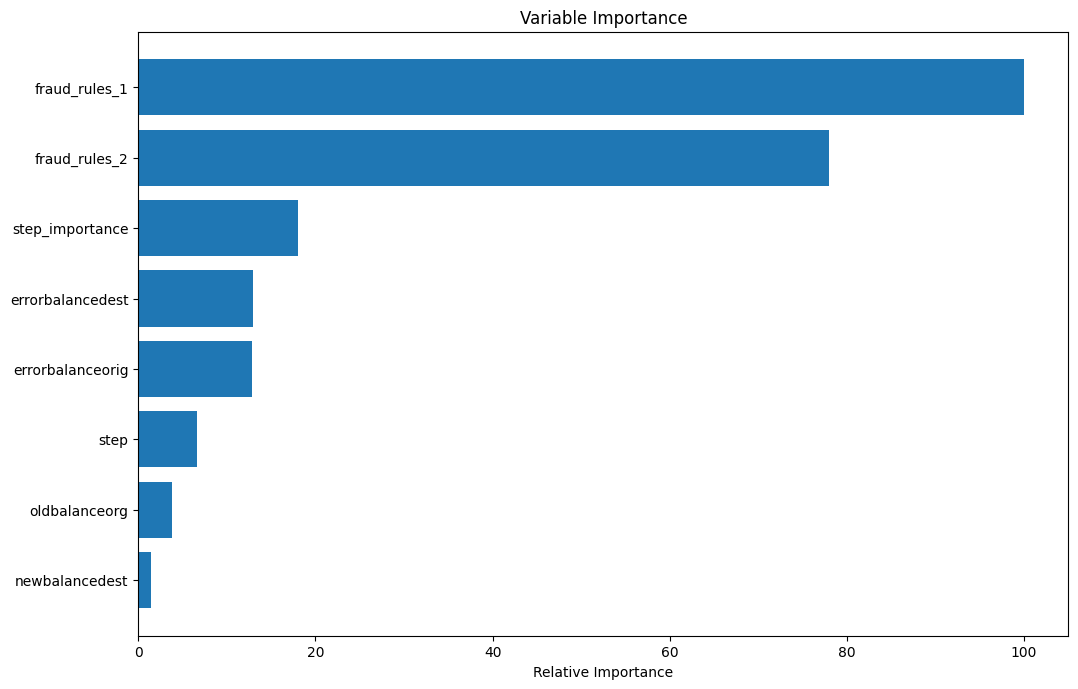

In [ ]:
feature_importance = model_rfc.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
# plt.subplot(1, 2, 2)
plt.figure(figsize=(12, 8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train_scaled.keys()[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

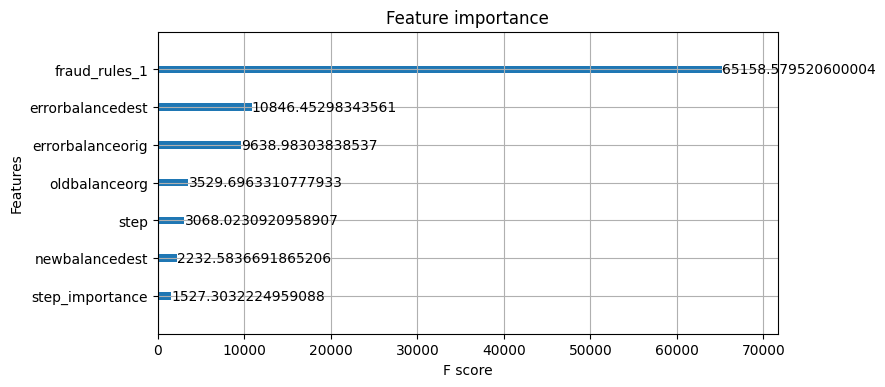

In [ ]:
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(model_xgb,importance_type='cover')
pyplot.show()

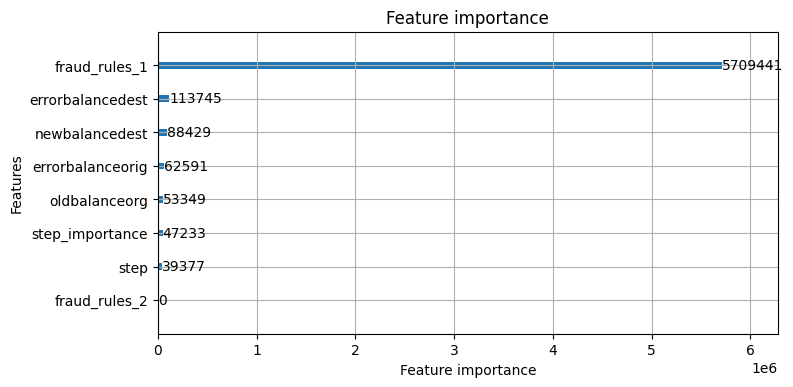

In [ ]:
# Feature importance
from lightgbm import plot_importance
plot_importance(model_lgb,importance_type='gain',precision=0,ignore_zero=False)

Computing partial dependence plots...


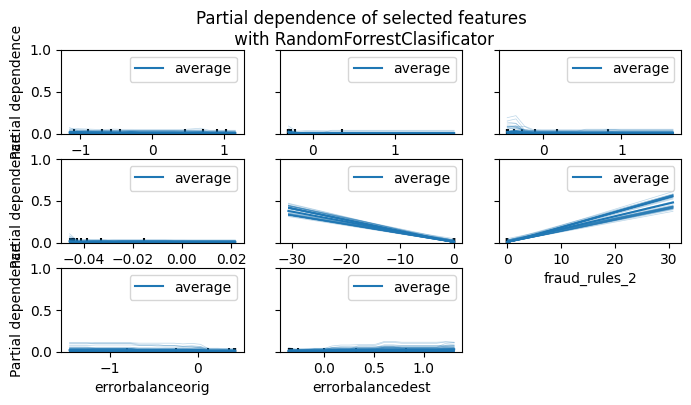

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

est=model_rfc.fit(X_train_scaled,y_train)

common_params = {
    "subsample": 80,
    "n_jobs": 2,
    "grid_resolution": 20,
    #"centered": True,
    "random_state": 0,
}

print("Computing partial dependence plots...")

display = PartialDependenceDisplay.from_estimator(
    est,
    X_train_scaled,
    features=X_train_scaled.columns,
    kind="both",
    **common_params,
)

display.figure_.suptitle(
    "Partial dependence of selected features\n"
    " with RandomForrestClasificator"
)
display.figure_.subplots_adjust(hspace=0.3)


In [ ]:
import lime
import lime.lime_tabular

In [ ]:
predict_fn_rf = lambda x: model_rfc.predict_proba(x).astype(float)
X = X_train_scaled.values
explainer = lime.lime_tabular.LimeTabularExplainer(X,feature_names = X_train_scaled.columns,class_names=['Legitima','Fraude'],kernel_width=5)

In [ ]:
X_test_scaled.loc[[1030724]]

step  oldbalanceorg  newbalancedest  step_importance  fraud_rules_1  \
1030724 3.7787        -0.2698         -0.3981           4.5614       -30.7191   

         fraud_rules_2  errorbalanceorig  errorbalancedest  
1030724        30.7191            0.4258           -0.0576

In [ ]:
choosen_instance = X_test_scaled.loc[[1030724]].values[0]
exp = explainer.explain_instance(choosen_instance, predict_fn_rf,num_features=10)
exp.show_in_notebook(show_all=False)

In [ ]:
choosen_instance = X_test_scaled.loc[[511473]].values[0]
exp = explainer.explain_instance(choosen_instance, predict_fn_rf,num_features=10)
exp.show_in_notebook(show_all=False)